In [71]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.svm import SVC
np.random.seed(2385128)


In [72]:
def draw_svm(clf, x, y, x1_min, x1_max, x2_min, x2_max, target=None):
    """
    Draws the decision boundary of an svm.
    :param clf: sklearn.svm.SVC classifier
    :param x: data Nx2
    :param y: label N
    :param x1_min: minimum value of the x-axis of the plot
    :param x1_max: maximum value of the x-axis of the plot
    :param x2_min: minimum value of the y-axis of the plot
    :param x2_max: maximum value of the y-axis of the plot
    :param target: if target is set to path, the plot is saved to that path
    :return: None
    """
    y = y.astype(bool)
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 500),
                         np.linspace(x2_min, x2_max, 500))
    z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    disc_z = z > 0
    plt.clf()
    plt.imshow(disc_z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
               origin='lower', cmap=plt.cm.RdBu, alpha=.3)
    plt.contour(xx, yy, z, levels=[-1, 1], linewidths=2,
                linestyles='dashed', colors=['red', 'blue'], alpha=0.5)
    plt.contour(xx, yy, z, levels=[0], linewidths=2,
                linestyles='solid', colors='black', alpha=0.5)
    positives = x[y == 1]
    negatives = x[y == 0]
    plt.scatter(positives[:, 0], positives[:, 1], s=50, marker='o', color="none", edgecolor="black")
    plt.scatter(negatives[:, 0], negatives[:, 1], s=50, marker='s', color="none", edgecolor="black")
    sv_label = y[clf.support_]
    positive_sv = x[clf.support_][sv_label]
    negative_sv = x[clf.support_][~sv_label]
    plt.scatter(positive_sv[:, 0], positive_sv[:, 1], s=50, marker='o', color="white", edgecolor="black")
    plt.scatter(negative_sv[:, 0], negative_sv[:, 1], s=50, marker='s', color="white", edgecolor="black")
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.gca().set_aspect('equal', adjustable='box')
    if target is None:
        return plt.show()
    else:
        plt.savefig(target)

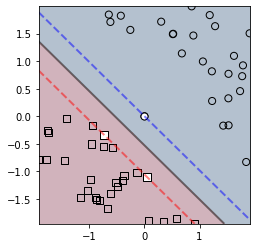

In [73]:
train_set = np.load("svm/task1/train_set.npy")
train_lbs = np.load("svm/task1/train_labels.npy")
path = "svm_results/task1/"
if not(os.path.exists(path) and os.path.isdir(path)):
    os.makedirs(path)
for c in [0.01,0.1,1,10,100]:
    clf = SVC(kernel='linear', C=c)
    clf = clf.fit(train_set, train_lbs)
    draw_svm(clf, train_set, train_lbs, train_set[:, 0].min(), train_set[:, 0].max(), train_set[:, 1].min(), train_set[:, 1].max(),target=f"svm_results/task1/c-{c}.png")

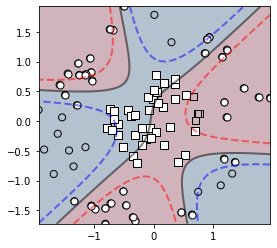

In [74]:
train_set = np.load("svm/task2/train_set.npy")
train_lbs = np.load("svm/task2/train_labels.npy")
path = "svm_results/task2/"
if not(os.path.exists(path) and os.path.isdir(path)):
    os.makedirs(path)
for kernel in ["linear","rbf","poly","sigmoid"]:
    clf = SVC(kernel=kernel, C=1)
    clf = clf.fit(train_set, train_lbs)
    draw_svm(clf, train_set, train_lbs, train_set[:, 0].min(), train_set[:, 0].max(), train_set[:, 1].min(), train_set[:, 1].max(),target=f"svm_results/task2/kernel-{kernel}.png")

In [75]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [76]:
def precision(cm):
    cm = np.rot90(cm,2).T
    return cm[0][0]/np.sum(cm[0])

def recall(cm):
    cm = np.rot90(cm,2).T
    if((cm[0][0]+cm[1][0]) == 0):
        return 0
    return cm[0][0]/np.sum(np.array(cm)[:,0])

def f1(cm):
    cm = np.rot90(cm,2).T
    if(precision(cm)+recall(cm) == 0):
        return 0
    return (precision(cm)*recall(cm)) /(precision(cm)+recall(cm))*2

def accuracy(cm):
    cm = np.rot90(cm,2).T
    return np.sum(np.trace(cm))/np.sum(cm)

In [77]:
train_set = np.load("svm/task3/train_set.npy")
train_lbs = np.load("svm/task3/train_labels.npy")
train_set = train_set.reshape((train_set.shape[0],train_set.shape[1]*train_set.shape[2]))

train_set, train_lbs = shuffle(train_set, train_lbs)

train_set_length = int(0.8 * len(train_set))
val_set = train_set[train_set_length:]
train_set = train_set[:train_set_length]
val_lbs = train_lbs[train_set_length:]
train_lbs = train_lbs[:train_set_length]

all_val_results = []
path = "svm_results/task3/"
if not(os.path.exists(path) and os.path.isdir(path)):
    os.makedirs(path)
for kernel in ["linear","rbf","poly","sigmoid"]:
    for c in [0.1,1,10]:
        for g in [0.1,0.3,0.5,0.7,0.9]:
            model = f"{kernel}-c-{c}-g-{g}"
            clf = SVC(kernel=kernel, C=c, gamma=g)
            clf = clf.fit(train_set, train_lbs)
            predictions = clf.predict(val_set)
            cm = confusion_matrix(val_lbs, predictions, labels=clf.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=clf.classes_)
            val_result_of_model = [accuracy(cm),precision(cm),recall(cm),f1(cm),kernel,c,g]
            all_val_results.append(val_result_of_model)

            # disp.plot()
            # plt.title(f"accuracy: {round(accuracy(cm),4)}\nprecision: {round(precision(cm),4)}\nrecall: {round(recall(cm),4)}\nf1: {round(f1(cm),4)}")
            # plt.savefig(path+model+".png")
np.savetxt(path+"results.csv", 
           all_val_results,
           delimiter =", ", 
           fmt ='% s')

best_c = all_val_results[np.argmax(np.array(all_val_results)[:,0])][5]
best_g = all_val_results[np.argmax(np.array(all_val_results)[:,0])][6]
best_kernel = all_val_results[np.argmax(np.array(all_val_results)[:,0])][4]

train_set = np.load("svm/task3/train_set.npy")
train_lbs = np.load("svm/task3/train_labels.npy")
test_set = np.load("svm/task3/test_set.npy")
test_lbs = np.load("svm/task3/test_labels.npy")

train_set = train_set.reshape((train_set.shape[0],train_set.shape[1]*train_set.shape[2]))
test_set = test_set.reshape((test_set.shape[0],test_set.shape[1]*test_set.shape[2]))

clf = SVC(kernel=best_kernel, C=best_c, gamma=best_g)
clf = clf.fit(train_set, train_lbs)

predictions = clf.predict(test_set)
cm = confusion_matrix(test_lbs, predictions, labels=clf.classes_)
print([accuracy(cm),precision(cm),recall(cm),f1(cm),best_kernel,best_c,best_g])

[0.763, 0.8079625292740047, 0.69, 0.7791239515377446, 'poly', 0.1, 0.1]


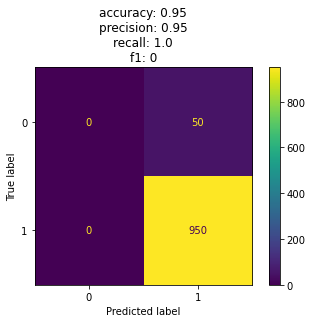

In [78]:
train_set = np.load("svm/task4/train_set.npy")
train_lbs = np.load("svm/task4/train_labels.npy")
train_set = train_set.reshape((train_set.shape[0],train_set.shape[1]*train_set.shape[2]))
test_set = np.load("svm/task4/test_set.npy")
test_lbs = np.load("svm/task4/test_labels.npy")
test_set = test_set.reshape((test_set.shape[0],test_set.shape[1]*test_set.shape[2]))

path = "svm_results/task4/"
if not(os.path.exists(path) and os.path.isdir(path)):
    os.makedirs(path)

clf = SVC(kernel="rbf", C=1)
clf = clf.fit(train_set, train_lbs)
predictions = clf.predict(test_set)
cm = confusion_matrix(test_lbs, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
test_result_of_model = [accuracy(cm),precision(cm),recall(cm),f1(cm)]

disp.plot()
plt.title(f"accuracy: {round(accuracy(cm),4)}\nprecision: {round(precision(cm),4)}\nrecall: {round(recall(cm),4)}\nf1: {round(f1(cm),4)}")
plt.savefig(path+"first_model.png")

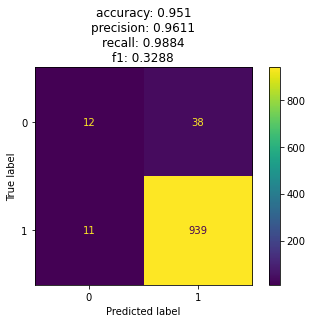

In [79]:
train_set = np.load("svm/task4/train_set.npy")
train_lbs = np.load("svm/task4/train_labels.npy")
train_set = train_set.reshape((train_set.shape[0],train_set.shape[1]*train_set.shape[2]))
test_set = np.load("svm/task4/test_set.npy")
test_lbs = np.load("svm/task4/test_labels.npy")
test_set = test_set.reshape((test_set.shape[0],test_set.shape[1]*test_set.shape[2]))

_, count = np.unique(np.array(train_lbs), return_counts=True)
delta = abs(count[0] - count[1])
minority = np.argwhere(train_lbs == 0).squeeze()
agumented_data = np.repeat(train_set[minority], repeats=(delta//minority.size), axis=0)
agumented_lbs = np.repeat(train_lbs[minority], repeats=(delta//minority.size), axis=0)
train_set = np.concatenate((train_set, agumented_data), axis=0)
train_lbs = np.concatenate((train_lbs, agumented_lbs), axis=0)
train_set, train_lbs = shuffle(train_set, train_lbs)

clf = SVC(kernel="rbf", C=1)
clf = clf.fit(train_set, train_lbs)
predictions = clf.predict(test_set)
cm = confusion_matrix(test_lbs, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
test_result_of_model = [accuracy(cm),precision(cm),recall(cm),f1(cm)]

disp.plot()
plt.title(f"accuracy: {round(accuracy(cm),4)}\nprecision: {round(precision(cm),4)}\nrecall: {round(recall(cm),4)}\nf1: {round(f1(cm),4)}")
plt.savefig(path+"second_model.png")

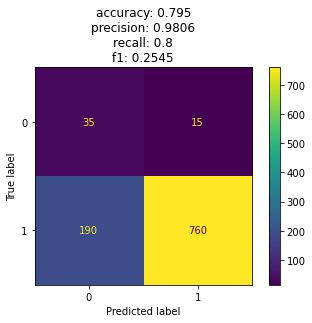

In [80]:
train_set = np.load("svm/task4/train_set.npy")
train_lbs = np.load("svm/task4/train_labels.npy")
train_set = train_set.reshape((train_set.shape[0],train_set.shape[1]*train_set.shape[2]))
test_set = np.load("svm/task4/test_set.npy")
test_lbs = np.load("svm/task4/test_labels.npy")
test_set = test_set.reshape((test_set.shape[0],test_set.shape[1]*test_set.shape[2]))

_, count = np.unique(np.array(train_lbs), return_counts=True)
minority_label = np.argmin((count[0], count[1]),axis=0)
minority_count = min(count[0], count[1])
sorted_args = np.argsort(train_lbs)
train_lbs = train_lbs[sorted_args][:minority_count*2]
train_set = train_set[sorted_args][:minority_count*2]

clf = SVC(kernel="rbf", C=1)
clf = clf.fit(train_set, train_lbs)
predictions = clf.predict(test_set)
cm = confusion_matrix(test_lbs, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
test_result_of_model = [accuracy(cm),precision(cm),recall(cm),f1(cm)]

disp.plot()
plt.title(f"accuracy: {round(accuracy(cm),4)}\nprecision: {round(precision(cm),4)}\nrecall: {round(recall(cm),4)}\nf1: {round(f1(cm),4)}")
plt.savefig(path+"third_model.png")

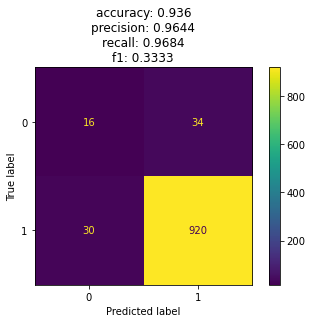

In [81]:
train_set = np.load("svm/task4/train_set.npy")
train_lbs = np.load("svm/task4/train_labels.npy")
train_set = train_set.reshape((train_set.shape[0],train_set.shape[1]*train_set.shape[2]))
test_set = np.load("svm/task4/test_set.npy")
test_lbs = np.load("svm/task4/test_labels.npy")
test_set = test_set.reshape((test_set.shape[0],test_set.shape[1]*test_set.shape[2]))

path = "svm_results/task4/"
if not(os.path.exists(path) and os.path.isdir(path)):
    os.makedirs(path)

clf = SVC(kernel="rbf", C=1, class_weight="balanced")
clf = clf.fit(train_set, train_lbs)
predictions = clf.predict(test_set)
cm = confusion_matrix(test_lbs, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
test_result_of_model = [accuracy(cm),precision(cm),recall(cm),f1(cm)]

disp.plot()
plt.title(f"accuracy: {round(accuracy(cm),4)}\nprecision: {round(precision(cm),4)}\nrecall: {round(recall(cm),4)}\nf1: {round(f1(cm),4)}")
plt.savefig(path+"fourth_model.png")